# Programmierung des Algorithmus

Wir werden nun den k-Means-Clustering Algorithmus Stück für Stück zusammenbauen. Um am Ende nicht ein großes Codefragment zu haben, versuchen wir, soviel Vorarbeit wie möglich zu erledigen, so dass du dich am Ende ganz auf die Implementierung des Algorithmus konzentrieren kannst (Stichwort: externe kognitive Belastung gering halten, siehe [Cognitive Load Theory \(CLT\)](https://de.wikipedia.org/wiki/Cognitive_Load_Theory 😉).

## Logging und Loglevel

Während der Programmierung ist es von großem Vorteil, Informationen, Warnungen und Fehler per **Logging** auszugeben. Diese Nachrichtensammlungen, **Logs** genannt, helfen dir, Fehler zu finden und die Ursache für Bugs zu verstehen.  

Nachrichten lassen sich mit verschiedenen **Loglevel** ausgeben. Das sind Kategorien, die angeben, wie wichtig eine Nachricht im Log ist. Meist gibt es die hierarchischen Loglevel `DEBUG`, `INFORMATION`, `WARNING`, `ERROR` und `FATAL`. Wie verwenden für unser Logging die Loglevel `DEBUG`, `INFORMATION`. Somit können wir generelle Programmablauf-Informationen ausgeben und auch mal Debug-Nachrichten, um einen Fehler in einer Methode zu finden. Hierarchisch bedeutet: wenn der Logleve `WARNING` gesetzt ist, dann werden alle Nachrichten $>=$ `WARNING` ausgegeben.

Damit du es in den Aufgaben einfacher hast, wird das Logging hier konfiguriert und aktiviert. Du kannst jederzeit
mit `logger.info()` und `logger.debug()` Nachrichten ausgeben. Nachrichten, die mit `logger.debug()` ausgegeben werden, werden nur angezeigt, wenn der Loglevel `DEBUG` gesetzt ist. Wenn du den Loglevel auf `logging.DEBUG` setzt, werden beide Nachrichten ausgegeben. Du kannst auch den Loglevel nur für bestimmte Bereiche oder Methoden ändern, siehe das Beispiel unten

```{admonition} Warum nicht print()
:class: note
Natürlich kannst du auch einfach alles mit `print()`-Befehlen ausgeben. Dann werden aber immer alle Nachrichten ausgegeben, außer du hast sie gerade auskommentiert. Mit dem Loglevel-Schalter lassen sich so bequem filtern, die du gerade brauchst, ohne die Nachrichten ein- und auskommentieren zu müssen.
```

In [145]:
import logging

# Konfiguration für das Logging
logging.basicConfig(format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Loglevel INFO:  Informationen über den Verlauf des Programms
# Loglevel DEBUG: Detaillierte Informationen für die Fehlersuche

# Info-Nachricht, hilfreich für den Programmverlauf
logger.info('Das Loggen ist eingerichtet')

# Debug-Nachricht, hilfreich für die Fehlersuche
logger.setLevel(logging.DEBUG)
logger.debug('Das Log-Level ist auf DEBUG gesetzt')
logger.debug('Diese Nachricht angezeigt, weil das Log-Level auf DEBUG gesetzt ist')
logger.setLevel(logging.INFO)
logger.info('Das Log-Level ist auf INFO gesetzt')
logger.debug('Diese Nachricht wird nicht angezeigt, weil das Log-Level wieder auf INFO gesetzt ist')

logger.setLevel(logging.INFO)

INFO: Das Loggen ist eingerichtet
DEBUG: Das Log-Level ist auf DEBUG gesetzt
DEBUG: Diese Nachricht angezeigt, weil das Log-Level auf DEBUG gesetzt ist
INFO: Das Log-Level ist auf INFO gesetzt


## Unit Tests

Wir werden zum Testen unserer Methoden **Unit-Tests** verwenden. Das sind kleine, automatisierte Tests, die jeweils eine **einzelne** Funktion oder Methode in einem Programm überprüfen. Sie helfen sicherzustellen, dass jede Komponente des Codes genau das tut, was sie tun soll. Stell dir Unit-Tests wie eine Checkliste vor, die jede Funktion Schritt für Schritt überprüft, ob sie die erwarteten Ergebnisse liefert.  

Bei den einzelnen Methoden sind die Unit-Tests bereits hinterlegt, sodass sie dir eine Hilfe bei der Implementierung geben.

```{admonition} Bei Interesse: weitere Infos zu Unit-Tests
:class: note, dropdown
**Vorteile von Unit-Tests:**

- **Frühes Erkennen von Fehlern**: Unit-Tests helfen dabei, Fehler früh zu finden, noch bevor der ganze Code zusammengesetzt wird. Das macht es einfacher und billiger, diese Fehler zu beheben.
- **Sicherheit bei Änderungen**: Wenn du etwas an deinem Code änderst, kannst du die Unit-Tests erneut ausführen, um sicherzustellen, dass die Änderung nichts kaputt gemacht hat. Sie geben also Vertrauen, dass alte Funktionen nach wie vor korrekt laufen.
- **Besserer Code**: Oft sorgt das Schreiben von Unit-Tests dafür, dass der eigentliche Code sauberer und verständlicher wird, weil man genau überlegen muss, was die Funktion tut.
- **Dokumentation**: Unit-Tests dokumentieren, wie der Code verwendet wird und welche Eingaben erwartete Ausgaben ergeben. Das hilft anderen Entwickler:innen (oder deinem zukünftigen Selbst), den Code besser zu verstehen.  

Mit Unit-Tests bist du also gut aufgestellt, um zuverlässigen und stabilen Code zu schreiben, der leichter zu warten ist.
```

```{warning}
Für die Unit-Tests benötigen wir die Python Bibliothek `pytest`. Falls diese nicht installiert ist, kann sie per Cmd oder Powershell mit dem Befehl `pip install pytest` installiert werden.
```

In [146]:
# Damit wir weiter unten die Unit-Tests ausführen können, importieren wir pytest
import pytest
import inspect

# Falls die Bibliothek pytest nicht installiert ist, kann sie mit dem Befehl
# pip install pytest
# installiert werden.
# simpler test für ptyest
def test_example():
    assert 1 == 1, "1 sollte gleich 1 sein"

test_example()


## Hilfsklasse `Datenpunkt`
Zunächst erstellen wir eine Hilfsklasse `Datenpunkt`, mit welcher wir die Koordinaten der Datenpunkte aus den Eingabedaten verwalten können. In dieser Klasse erweitern wir noch die internen Methoden `__eq__()` und `__hash__()`, damit wir es später leichter haben, die neuen Zentroiden mit den alten Zentroiden der vorigen Iteration zu vergleichen (siehe Schritt 5 des [Algorithmus](#k-means-clustering-algorithmus)).

```{admonition} Zentroiden & Datenpunkte
:class: note
Zentroiden sind nichts anderes als Datenpunkte wie aus den Eingabedaten. Beide zeichnet aus, dass sie `X`- und `Y`-Koordinaten haben.
```

In [147]:
class Datenpunkt:
    """Klasse zur Darstellung eines Datenpunktes im 2D-Raum."""
    def __init__(self, x: float, y: float) -> None:
        """Initialisiert einen Datenpunkt mit den gegebenen Koordinaten, gerundet auf zwei Dezimalstellen."""
        self.x = round(x, 2)
        self.y = round(y, 2)

    def __eq__(self, anderer_datenpunkt: object) -> bool:
        """Vergleicht zwei Datenpunkte basierend auf ihren Koordinaten."""
        if isinstance(anderer_datenpunkt, Datenpunkt):
            return self.x == anderer_datenpunkt.x and self.y == anderer_datenpunkt.y
        return False
    
    def __hash__(self) -> int:
        """Berechnet den Hashwert eines Datenpunktes."""
        return hash((self.x, self.y))
    
    def __repr__(self) -> str:
        """Gibt eine lesbare Repräsentation eines Datenpunktes zurück."""
        return f"Datenpunkt({self.x}, {self.y})"

logger.info('Klasse Datenpunkt definiert')
logger.debug(Datenpunkt(1.23456789, 2.3456789))  # Ausgabe: Datenpunkt(1.23, 2.35)    

INFO: Klasse Datenpunkt definiert


Unit-Tests für `Datenpunkt`:

In [148]:
def test_datenpunkt_erstellt_richtige_koordinaten():
    # Erfolgreicher Testfall zur Überprüfung der Initialisierung
    punkt = Datenpunkt(3.456, 7.891)
    assert punkt.x == 3.46, f"Erwarteter x-Wert: 3.46, aber erhalten: {punkt.x}"  # Erwartetes Runden auf zwei Dezimalstellen
    assert punkt.y == 7.89, f"Erwarteter y-Wert: 7.89, aber erhalten: {punkt.y}"

def test_datenpunkt_gleichheit():
    # Erfolgreicher Testfall zur Überprüfung der Gleichheit
    punkt1 = Datenpunkt(2.0, 3.0)
    punkt2 = Datenpunkt(2.00, 3.00)
    assert punkt1 == punkt2, f"Die Datenpunkte sollten gleich sein: {punkt1} und {punkt2}"  # Erwartet, dass die Punkte gleich sind

    # Failing Testcase zur Überprüfung der Ungleichheit
    punkt3 = Datenpunkt(2.0, 3.0)
    punkt4 = Datenpunkt(3.0, 2.0)
    assert punkt3 != punkt4, f"Die Datenpunkte sollten ungleich sein: {punkt3} und {punkt4}"  # Erwartet, dass die Punkte ungleich sind

test_datenpunkt_erstellt_richtige_koordinaten()
test_datenpunkt_gleichheit()
print("Datenpunkt-Tests erfolgreich durchgelaufen!")

Datenpunkt-Tests erfolgreich durchgelaufen!


## Generieren zufälliger Datenpunkte

Wir möchten uns keine Datenpunkte ausdenken müssen und unsere spätere `kmeans()`-Methode mit beliebig großen Datensätzen testen können. Dafür verwenden wir die Methode `generiere_datenpunkte()`. Dieser können wir die Anzahl der gewünschten Datenpunkte und den gewünschten Zahlenraum angeben. Wir erhalten eine Liste von `Datenpunkten` zurück.

In [149]:
import random

# Damit wir einerseits zufällige Zahlen generieren können, aber andererseits auch reproduzierbare
# Ergebnisse erhalten, setze wir den Zufallsgenerator auf einen fixen Wert.
random.seed(42)

def generiere_datenpunkte(anzahl_datenpunkte: int, zahlenraum: int = 10) -> list[Datenpunkt]:
    """Generiert eine Liste von zufälligen Datenpunkten im angegebenen Zahlenraum.  
       Return: Liste der generierten Datenpunkte.  
       Z.B: [Datenpunkt(1.4, 2.3), Datenpunkt(3.1, 4.5), Datenpunkt(5.7, 6.2)]"""
    # Set, um Duplikate zu vermeiden
    datenpunkte = set()
    # Solange die Anzahl der generierten Datenpunkte kleiner als die gewünschte Anzahl ist,
    # neue Datenpunkte generieren und hinzufügen
    while len(datenpunkte) < anzahl_datenpunkte:
        # Zufällige Koordinaten im Zahlenraum generieren
        x = random.uniform(0, zahlenraum)
        y = random.uniform(0, zahlenraum)
        datenpunkt = Datenpunkt(x, y)
        datenpunkte.add(datenpunkt)
    logger.info(f"Generierte Datenpunkte im {zahlenraum}x{zahlenraum} Zahlenraum: {datenpunkte}")
    return list(datenpunkte)

logger.info('Funktion generiere_datenpunkte definiert')
logger.debug(generiere_datenpunkte(3))  # Ungefähre Ausgabe: [Datenpunkt(1.4, 2.3), Datenpunkt(3.1, 4.5), Datenpunkt(5.7, 6.2)]


INFO: Funktion generiere_datenpunkte definiert
INFO: Generierte Datenpunkte im 10x10 Zahlenraum: {Datenpunkt(2.75, 2.23), Datenpunkt(7.36, 6.77), Datenpunkt(6.39, 0.25)}


Unit-Tests für `generiere_datenpunkte()`:

In [150]:
def test_generiere_datenpunkte():
    # Testfall zur Überprüfung der Generierung von Datenpunkten
    anzahl_datenpunkte = 5
    zahlenraum = 10
    datenpunkte = generiere_datenpunkte(anzahl_datenpunkte, zahlenraum)
    assert len(datenpunkte) == anzahl_datenpunkte, f"Erwartete Anzahl der Datenpunkte: {anzahl_datenpunkte}, aber erhalten: {len(datenpunkte)}"
    for datenpunkt in datenpunkte:
        assert 0 <= datenpunkt.x <= 10, f"Erwartet, dass x innerhalb des Zahlenraums {zahlenraum} liegt, aber erhalten: {datenpunkt.x}"
        assert 0 <= datenpunkt.y <= 10, f"Erwartet, dass y innerhalb des Zahlenraums {zahlenraum} liegt, aber erhalten: {datenpunkt.y}"

test_generiere_datenpunkte()

INFO: Generierte Datenpunkte im 10x10 Zahlenraum: {Datenpunkt(6.5, 5.45), Datenpunkt(0.27, 1.99), Datenpunkt(4.22, 0.3), Datenpunkt(8.92, 0.87), Datenpunkt(2.19, 5.05)}


## Zentroiden initialisieren

Nun geht es in Richtung des k-Mean-Clustering Algorithmus. Die Methode `initialisiere_zentroiden` wählt aus der übergebenen Liste von Datenpunkten zufällig die gewünschte Anzahl der Zentroiden aus. Die Auswahl ist zwar **zufällig**, bleibt **aber reproduzierbar**, weil wir ja weiter oben schon den Zufallsgenerator auf einen fixen Wert gesetzt haben. Die Methode gibt eine Liste von `Datenpunkten` zurück.

In [151]:
def initialisiere_zentroiden(datenpunkte: list[Datenpunkt], anzahl_zentroiden: int) -> list[Datenpunkt]:
    """Wählt zufällig die angegebene Anzahl von Zentroiden aus den Datenpunkten aus.  
       Return: Liste der initialisierten Zentroiden.  
       Z.B: [Datenpunkt(1.4, 4.5), Datenpunkt(5.2, 8.3), Datenpunkt(3.1, 9.2)]"""
    zentroiden = random.sample(datenpunkte, anzahl_zentroiden)
    return zentroiden

logger.info('Funktion initialisiere_zentroiden definiert')
temp_datenpunkte = generiere_datenpunkte(10)
temp_zentroiden = initialisiere_zentroiden(temp_datenpunkte, 2)
# Ungefähre Ausgabe: Initialisierte Zentroiden: [Datenpunkt(1.4, 2.3), Datenpunkt(3.1, 4.5)]
logger.debug(f"Initialisierte Zentroiden: {temp_zentroiden}")

INFO: Funktion initialisiere_zentroiden definiert
INFO: Generierte Datenpunkte im 10x10 Zahlenraum: {Datenpunkt(8.47, 6.04), Datenpunkt(5.36, 9.73), Datenpunkt(8.06, 6.98), Datenpunkt(0.93, 0.97), Datenpunkt(3.79, 5.52), Datenpunkt(8.07, 7.3), Datenpunkt(3.4, 1.55), Datenpunkt(9.57, 3.37), Datenpunkt(8.09, 0.06), Datenpunkt(2.2, 5.89)}


Unit-Tests für `initialisiere_zentroiden()`:

In [152]:
def test_initialisiere_zentroiden():
    # Testfall zur Überprüfung der Initialisierung der Zentroiden
    datenpunkte = [Datenpunkt(x, y) for x, y in [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10)]]
    anzahl_zentroiden = 5
    zentroiden = initialisiere_zentroiden(datenpunkte, anzahl_zentroiden)
    assert len(zentroiden) == anzahl_zentroiden, f"Erwartete Anzahl der Zentroiden: {anzahl_zentroiden}, aber erhalten: {len(zentroiden)}"
    for zentroid in zentroiden:
        assert zentroid in datenpunkte, f"Erwartet, dass der Zentroid aus den Datenpunkten stammt, aber erhalten: {zentroid}"

test_initialisiere_zentroiden()

---

```{admonition} Your turn
:class: tip
**Ab hier beginnt dein Teil der Arbeit, viel Spaß und Erfolg 💪**
```

# Aufgabe 1: Berechnen der Distanz zwischen zwei Datenpunkten

Du brauchst eine Methode, welche dir die Distanz zwischen zwei Datenpunkten berechnet. Wir werden hierfür als [Distanzmaße](#distanzmasse) die Euklidische Distanz verwenden. Die Methode erhält zwei Datenpunkte und gibt die Distanz auf zwei Nachkommastellen gerundet zurück (siehe [round()](https://www.w3schools.com/python/ref_func_round.asp)).

In [ ]:
def berechne_euklidische_distanz(datenpunkt1: Datenpunkt, datenpunkt2: Datenpunkt) -> float:
    """Berechne die euklidische Distanz zu einem anderen Datenpunkt.  
        Return: Euklidische Distanz zwischen zwei Datenpunkten.  
        Z.B: 2.83"""
    ...  # Hier Lösung ergänzen

logger.info('Funktion berechne_euklidische_distanz definiert')

INFO: Funktion berechne_euklidische_distanz definiert


Unit-Tests für `berechne_euklidische_distanz()`:

In [154]:
def test_berechne_euklidische_distanz():
    # Erfolgreicher Testfall
    punkt1 = Datenpunkt(1, 1)
    punkt2 = Datenpunkt(4, 5)
    result = berechne_euklidische_distanz(punkt1, punkt2)
    assert result == 5.0, f"Erwarteter Wert: 5.0, aber erhalten: {result}"  # Erwarteter Wert ist 5.0

    # Failing Testcase
    punkt3 = Datenpunkt(2, 3)
    punkt4 = Datenpunkt(6, 9)
    result = berechne_euklidische_distanz(punkt3, punkt4)
    assert result != 7.0, f"Erwartet einen Wert ungleich 7.0, aber erhalten: {result}"  # Falscher Wert, zum Testen der Fehlerbedingung

def test_berechne_euklidische_distanz_rundung():
    # Testfall zur Überprüfung der Rundung
    punkt1 = Datenpunkt(0, 0)
    punkt2 = Datenpunkt(1, 1)
    result = berechne_euklidische_distanz(punkt1, punkt2)
    assert result == 1.41, f"Erwarteter gerundeter Wert: 1.41, aber erhalten: {result}"  # Erwartet, dass der Wert korrekt gerundet wird

test_berechne_euklidische_distanz()
test_berechne_euklidische_distanz_rundung()

# Aufgabe 2: Ermitteln des nächsten (besten) Zentroiden

Nun wollen wir für einen `Datenpunkt` den nächstgelegenen Zentroiden ermitteln. Wir bekommen dafür die Liste von Zentroiden übergeben und müssen hieraus nun den Zentroiden ermitteln, zu dem die Distanz des `Datenpunkts` am geringsten ist. Überlege dir vorher, wie du vorgehen möchtest. Zurückgegeben wird der Index des ermittelten Zentroiden. Wenn also der 3. Zentroid der nächstgelegene ist, dann muss der Index 2 zurückgegeben wird (da Index bei 0 beginnt).

In [ ]:
def finde_naechsten_zentroiden(zentroiden: list[Datenpunkt], datenpunkt: Datenpunkt) -> int:
    """Finde den nächsten Zentroiden für einen gegebenen Datenpunkt. Wenn es mehrere Zentroiden mit
       der gleichen minimalen Distanz gibt, wird der erste gefundene Zentroid zurückgegeben.
       Return: Index (!) des nächsten Zentroiden.  
       Z.B: 2 bedeutet, dass der dritte (!) Zentroid der nächstgelegene für den Datenpunkt ist."""
    ...  # Hier Lösung ergänzen

logger.info('Funktion finde_naechsten_zentroiden definiert')

INFO: Funktion finde_naechsten_zentroiden definiert


Unit-Tests für `finde_naechsten_zentroiden()`:

In [156]:
def test_finde_naechsten_zentroiden():
    # Testfall zur Überprüfung der Funktion finde_naechsten_zentroiden
    datenpunkte = [Datenpunkt(x, y) for x, y in [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10)]]
    datenpunkt = Datenpunkt(4, 5)
    naechster_zentroid_index = finde_naechsten_zentroiden(datenpunkte, datenpunkt)
    assert naechster_zentroid_index == 1, f"Erwarteter nächster Zentroid Index: 1, aber erhalten: {naechster_zentroid_index}"

test_finde_naechsten_zentroiden()

# Aufgabe 3: Erzeugen der Cluster

Nachdem wir den nächsten Zentroiden zu einem Datenpunkt berechnen können, sind wir nun in der Lage, alle Datenpunkte zu clustern. Mit der Methode `weise_cluster_zu()` können wir nun für jeden Datenpunkt den nächsten Zentroiden ermitteln und daraus die Cluster bilden.

In der Methode unten ist bereits das Erzeugen der leeren Cluster erfolgt, darum musst du dich nicht kümmern. Was du noch ergänzen musst, ist das Ermitteln des nächsten Zentroiden zu jedem Datenpunkt. Mit dem erhaltenen Index kannst du im Dictionary dann den Datenpunkt dem zugehörigen Cluster anhängen.

In [ ]:
def erzeuge_cluster(datenpunkte: list[Datenpunkt], zentroiden: list[Datenpunkt]) -> dict[int, list[Datenpunkt]]:
    """Weist jeden Datenpunkt den entsprechenden Cluster zu.  
       Return: Dictionary mit den Clustern und den zugehörigen Datenpunkten.
        Z.B: {0: [Datenpunkt(1.4, 4.5), Datenpunkt(1.6, 4.7)], 1: [Datenpunkt(5.2, 8.3), Datenpunkt(5.1, 8.2)], 2: [Datenpunkt(3.1, 9.2)]}"""
    clusters: dict[int, list[Datenpunkt]] = {}
    for zentroid in range(len(zentroiden)):
        clusters[zentroid] = []
    ...  # Hier die weitere Lösung ergänzen

logger.info('Funktion weise_cluster_zu definiert')

INFO: Funktion weise_cluster_zu definiert


Unit-Tests für `erzeuge_cluster()`:

In [158]:
def test_erzeuge_cluster():
    # Testfall zur Überprüfung der Zuweisung der Datenpunkte zu den nächsten Zentroiden
    datenpunkte = [Datenpunkt(x, y) for x, y in [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10)]]
    zentroiden = [Datenpunkt(2, 3), Datenpunkt(6, 7), Datenpunkt(8, 9)]
    clusters = erzeuge_cluster(datenpunkte, zentroiden)
    erwartete_clusters = {
        0: [Datenpunkt(1, 2), Datenpunkt(3, 4)],
        1: [Datenpunkt(5, 6), Datenpunkt(7, 8)],
        2: [Datenpunkt(9, 10)]
    }
    for cluster_index, datenpunkte_im_cluster in erwartete_clusters.items():
        assert len(clusters[cluster_index]) == len(datenpunkte_im_cluster), f"Erwartete Anzahl der Datenpunkte im Cluster {cluster_index}: {len(datenpunkte_im_cluster)}, aber erhalten: {len(clusters[cluster_index])}"
        for datenpunkt in datenpunkte_im_cluster:
            assert datenpunkt in clusters[cluster_index], f"Erwarteter Datenpunkt {datenpunkt} nicht im Cluster {cluster_index} gefunden"

test_erzeuge_cluster()

# Aufgabe 4: Aktualisieren der Zentroiden

Wir kommen der fertigen Implementierung des K-Means-Algorithmus immer näher.

## Koordinaten eines Zentroiden berechnen
 Wir benötigen nun zum einen noch eine Funktion `berechne_zentroid_koordinaten()`, welche uns aus den Datenpunkten eines Clusters die neuen Koordinaten des Zentroiden berechnet. Diese Funktion wird dann von `aktualisiere_zentroiden()` verwendet, um die Zentroiden in jeder Iteration alle neu zu berechnen.

In [ ]:
def berechne_zentroid_koordinaten(datenpunkte: list[Datenpunkt]) -> Datenpunkt:
    """Berechnet die Koordinaten des Zentroiden basierend auf den zugehörigen Datenpunkten. Dabei wird
       der Mittelwert der X- und Y-Koordinaten der Datenpunkte berechnet.
       Return: Position des Zentroiden als Datenpunkt.  
       Z.B: Datenpunkt(2.5, 3.7)"""
    ...  # Hier Lösung ergänzen

logger.info('Funktion berechne_zentroid definiert')

INFO: Funktion berechne_zentroid definiert


Unit-Tests für `berechne_zentroid_koordinaten()`:

In [160]:
def test_berechne_zentroid_koordinaten():
    logger.info('Testfall für die Berechnung des Zentroiden')
    # Testfall zur Überprüfung der Berechnung des Zentroiden
    datenpunkte = [Datenpunkt(x, y) for x, y in [(1, 1), (2, 3), (5, 6), (7, 8), (9, 10)]]
    zentroid = berechne_zentroid_koordinaten(datenpunkte)
    assert zentroid.x == 4.8, f"Erwarteter x-Wert des Zentroiden: 4.8, aber erhalten: {zentroid.x}"
    assert zentroid.y == 5.6, f"Erwarteter y-Wert des Zentroiden: 5.6, aber erhalten: {zentroid.y}"

test_berechne_zentroid_koordinaten()

INFO: Testfall für die Berechnung des Zentroiden


## Zentroiden für alle Cluster neu berechnen

Nun wird es spannend: Mit Hilfe der vorigen Methode `berechne_zentroid_koordinaten()` kannst du nun für alle Cluster die Zentroiden neu berechnen lassen. `aktualisiere_zentroiden()` erhält dabei ein Dictionary der Clusters. Ein Eintrag im Dictionary ist dabei der Index des Clusters und die dazugehörigen Datenpunkte. Es ist möglich, über die Werte des Dictionary zu iterieren mit `dict.values()`

Ein Beispiel:
```python
clusters = {
    0: [Datenpunkt(1, 1), Datenpunkt(2, 2)],
    1: [Datenpunkt(4, 4), Datenpunkt(5, 5)],
    2: [Datenpunkt(8, 8), Datenpunkt(9, 9)]
}

for datenpunkte_in_cluster in clusters.values():
    ...
```

In [ ]:
def aktualisiere_zentroiden(clusters: dict[int, list[Datenpunkt]]) -> list[Datenpunkt]:
    """Aktualisiert die Zentroiden basierend auf den zugewiesenen Datenpunkten.  
       Return: Liste der neuen Zentroiden.  
       Z.B: [Datenpunkt(1.4, 4.5), Datenpunkt(5.2, 8.3), Datenpunkt(3.1, 9.2)]"""
    ...  # Hier Lösung ergänzen
    
logger.info('Funktion aktualisiere_zentroiden definiert')

Unit-Tests für `aktualisiere_zentroiden()`:

In [162]:
def test_aktualisiere_zentroiden_einfach():
    # Testfall zur Überprüfung der Aktualisierung der Zentroiden
    clusters = {
        0: [Datenpunkt(1, 1), Datenpunkt(2, 2)],
        1: [Datenpunkt(4, 4), Datenpunkt(5, 5)],
        2: [Datenpunkt(8, 8), Datenpunkt(9, 9)]
    }
    aktualisierte_zentroiden = aktualisiere_zentroiden(clusters)
    erwartete_zentroiden = [
        Datenpunkt(1.5, 1.5),
        Datenpunkt(4.5, 4.5),
        Datenpunkt(8.5, 8.5)
    ]
    for i in range(len(aktualisierte_zentroiden)):
        assert aktualisierte_zentroiden[i] == erwartete_zentroiden[i], f"Erwarteter Zentroid: {erwartete_zentroiden[i]}, aber erhalten: {aktualisierte_zentroiden[i]}"

def test_aktualisiere_zentroiden_komplex():
    # Testfall zur Überprüfung der Aktualisierung der Zentroiden mit mehr Variabilität
    clusters = {
        0: [Datenpunkt(1, 2), Datenpunkt(2, 3), Datenpunkt(3, 4)],
        1: [Datenpunkt(5, 5), Datenpunkt(6, 7), Datenpunkt(7, 8)],
        2: [Datenpunkt(8, 9), Datenpunkt(10, 11), Datenpunkt(12, 13)]
    }
    aktualisierte_zentroiden = aktualisiere_zentroiden(clusters)
    erwartete_zentroiden = [
        Datenpunkt(2.0, 3.0),  # Durchschnitt der ersten Cluster-Datenpunkte (1,2), (2,3), (3,4)
        Datenpunkt(6.0, 6.67),  # Durchschnitt der zweiten Cluster-Datenpunkte (5,5), (6,7), (7,8)
        Datenpunkt(10.0, 11.0)  # Durchschnitt der dritten Cluster-Datenpunkte (8,9), (10,11), (12,13)
    ]
    for i in range(len(aktualisierte_zentroiden)):
        assert round(aktualisierte_zentroiden[i].x, 2) == round(erwartete_zentroiden[i].x, 2), f"Erwarteter Zentroid X-Wert: {erwartete_zentroiden[i].x}, aber erhalten: {aktualisierte_zentroiden[i].x}"
        assert round(aktualisierte_zentroiden[i].y, 2) == round(erwartete_zentroiden[i].y, 2), f"Erwarteter Zentroid Y-Wert: {erwartete_zentroiden[i].y}, aber erhalten: {aktualisierte_zentroiden[i].y}"

test_aktualisiere_zentroiden_einfach()
test_aktualisiere_zentroiden_komplex()


INFO: Aktualisierte Zentroiden: [Datenpunkt(1.5, 1.5), Datenpunkt(4.5, 4.5), Datenpunkt(8.5, 8.5)]
INFO: Aktualisierte Zentroiden: [Datenpunkt(2.0, 3.0), Datenpunkt(6.0, 6.67), Datenpunkt(10.0, 11.0)]


# Finale: k-Means-Clustering vollendet

Wir haben nun alle nötigen Untermethoden für den Algorithmus erzeugt und können ihn nun starten.

INFO: Generierte Datenpunkte im 10x10 Zahlenraum: {Datenpunkt(4.79, 1.82), Datenpunkt(5.36, 6.32), Datenpunkt(9.18, 3.87), Datenpunkt(3.35, 3.3), Datenpunkt(2.0, 6.05), Datenpunkt(0.44, 3.87), Datenpunkt(1.04, 5.82), Datenpunkt(9.97, 9.12), Datenpunkt(9.11, 8.17), Datenpunkt(5.58, 3.87), Datenpunkt(9.91, 5.24), Datenpunkt(1.55, 2.96), Datenpunkt(3.1, 6.56), Datenpunkt(2.02, 7.91), Datenpunkt(7.15, 3.35), Datenpunkt(5.27, 6.62), Datenpunkt(2.41, 6.57), Datenpunkt(5.01, 9.58), Datenpunkt(1.35, 7.16), Datenpunkt(6.25, 9.03), Datenpunkt(6.43, 8.3), Datenpunkt(0.82, 2.25), Datenpunkt(9.53, 5.44), Datenpunkt(2.91, 0.02), Datenpunkt(3.1, 3.98), Datenpunkt(2.38, 1.22), Datenpunkt(3.73, 7.47), Datenpunkt(1.87, 6.68), Datenpunkt(9.66, 7.84), Datenpunkt(3.64, 7.2), Datenpunkt(3.57, 0.68), Datenpunkt(1.92, 10.0), Datenpunkt(3.19, 0.99), Datenpunkt(1.5, 0.82), Datenpunkt(2.52, 8.52), Datenpunkt(5.16, 1.25), Datenpunkt(7.78, 5.03), Datenpunkt(9.7, 6.11), Datenpunkt(4.51, 8.11), Datenpunkt(1.88, 6.05

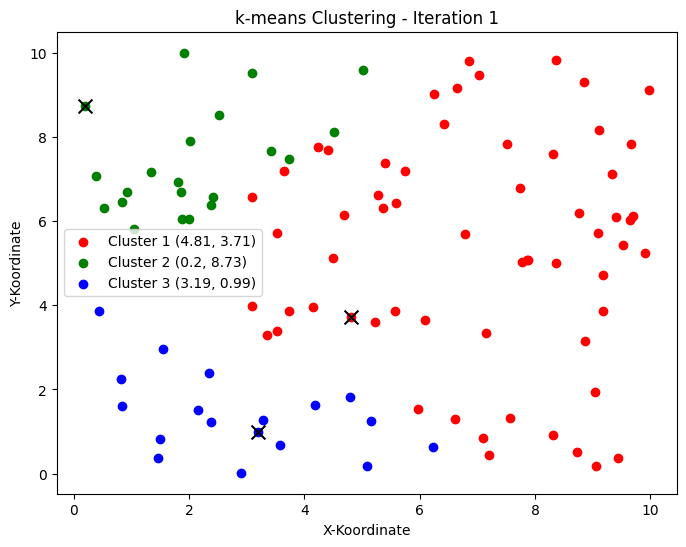

INFO: Aktualisierte Zentroiden: [Datenpunkt(6.97, 5.31), Datenpunkt(2.09, 7.41), Datenpunkt(2.88, 1.41)]
INFO: Iteration 2


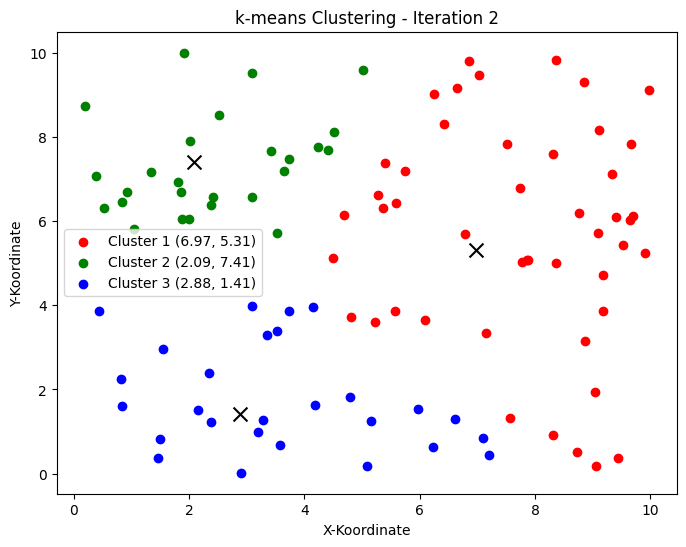

INFO: Aktualisierte Zentroiden: [Datenpunkt(7.69, 5.67), Datenpunkt(2.41, 7.33), Datenpunkt(3.58, 1.78)]
INFO: Iteration 3


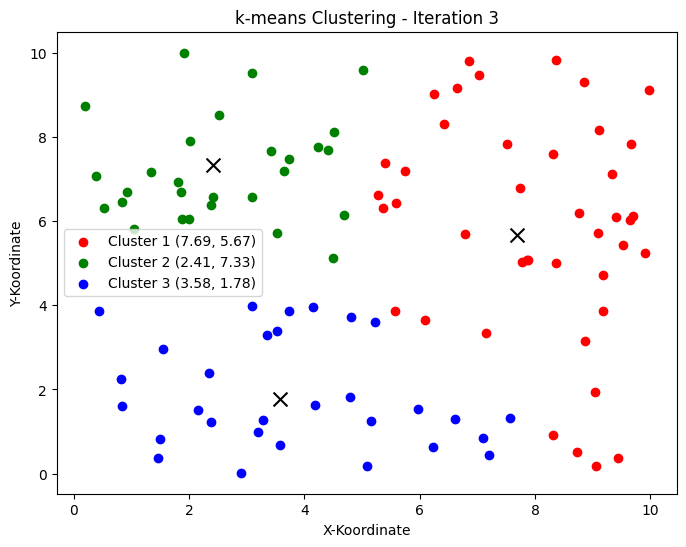

INFO: Aktualisierte Zentroiden: [Datenpunkt(7.97, 5.87), Datenpunkt(2.57, 7.21), Datenpunkt(3.81, 1.89)]
INFO: Iteration 4


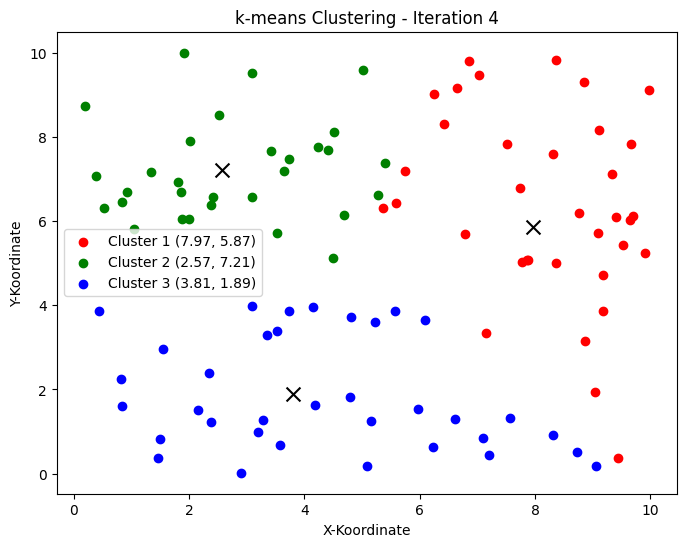

INFO: Aktualisierte Zentroiden: [Datenpunkt(8.18, 6.38), Datenpunkt(2.75, 7.2), Datenpunkt(4.34, 1.88)]
INFO: Iteration 5


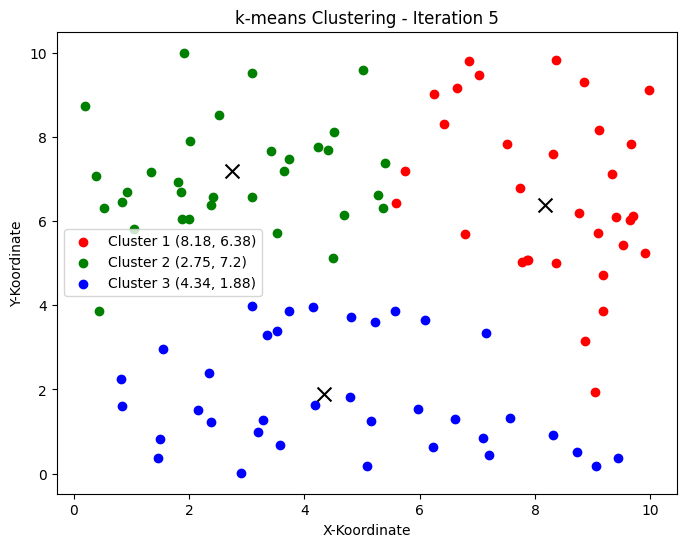

INFO: Aktualisierte Zentroiden: [Datenpunkt(8.26, 6.67), Datenpunkt(2.76, 7.07), Datenpunkt(4.67, 1.83)]
INFO: Iteration 6


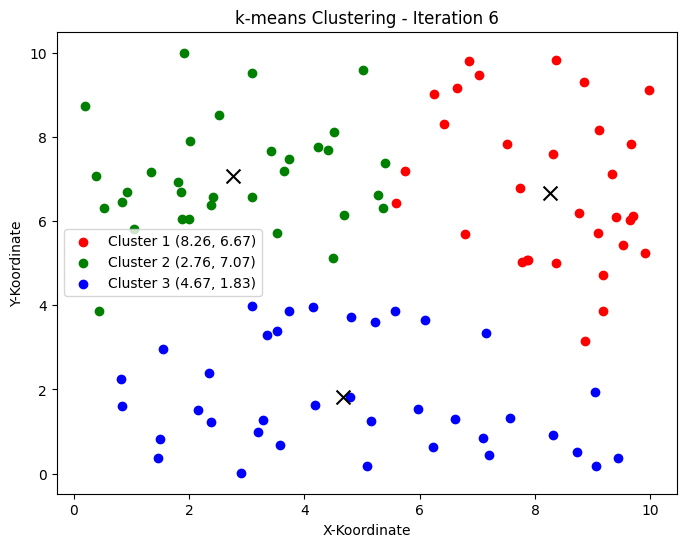

INFO: Aktualisierte Zentroiden: [Datenpunkt(8.24, 6.82), Datenpunkt(2.76, 7.07), Datenpunkt(4.79, 1.83)]
INFO: Iteration 7


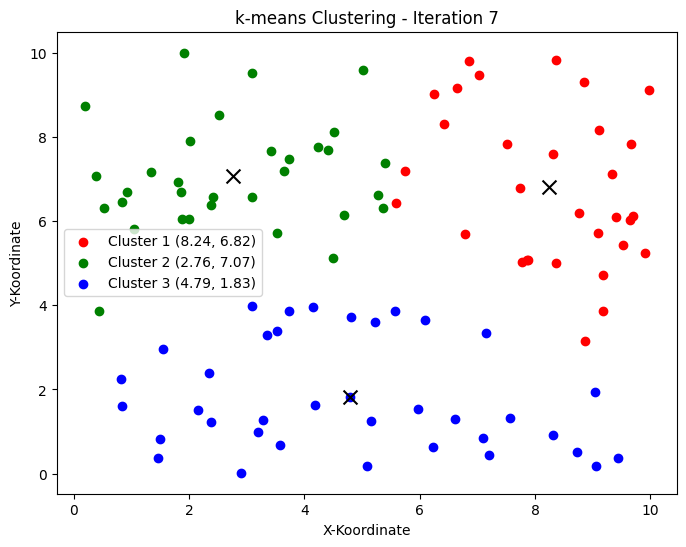

INFO: Aktualisierte Zentroiden: [Datenpunkt(8.24, 6.82), Datenpunkt(2.76, 7.07), Datenpunkt(4.79, 1.83)]
INFO: Zentroiden haben sich nicht mehr verändert. Algorithmus stoppt.
INFO: Endgültige Zentroiden: [Datenpunkt(8.24, 6.82), Datenpunkt(2.76, 7.07), Datenpunkt(4.79, 1.83)]


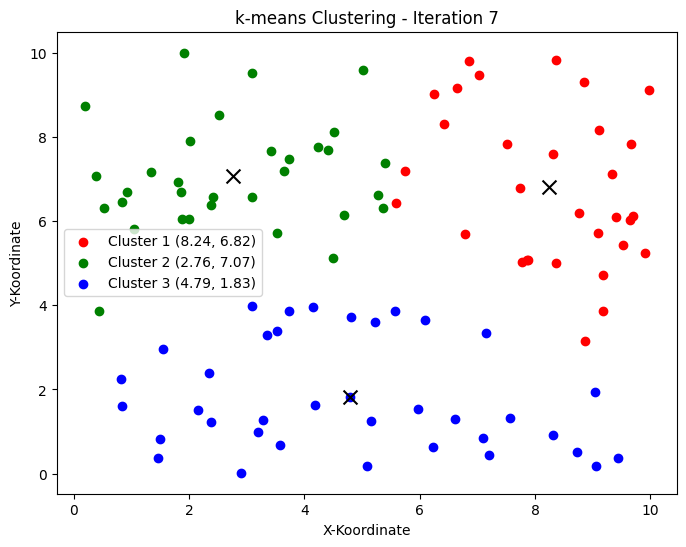

In [ ]:

def k_means(datenpunkte: list[Datenpunkt], anzahl_cluster: int, max_iterationen: int) -> None:
    """Hauptfunktion für den k-means Algorithmus. Führt den k-means Clustering Algorithmus aus."""
    # 2. Initialisierung der Zentroiden
    zentroiden = initialisiere_zentroiden(datenpunkte, anzahl_cluster)

    for iteration in range(max_iterationen):
        logger.info(f"Iteration {iteration + 1}")
        # 3. Zuweisung der Datenpunkte und Bildung der Cluster
        clusters = erzeuge_cluster(datenpunkte, zentroiden)
        plot_cluster(clusters, zentroiden, iteration + 1)
        
        # 4. Aktualisierung der Zentroiden
        neue_zentroiden = aktualisiere_zentroiden(clusters)
        
        # 5. Überprüfung, ob sich die Zentroiden verändert haben
        if neue_zentroiden == zentroiden:
            logger.info("Zentroiden haben sich nicht mehr verändert. Algorithmus stoppt.")
            break
        zentroiden = neue_zentroiden
    logger.info(f"Endgültige Zentroiden: {zentroiden}")

# Starte den k-means Algorithmus mit 100 Datenpunkten, 3 Zentroiden und maximal 10 Iterationen
datenpunkte = generiere_datenpunkte(100, zahlenraum=10)
k_means(datenpunkte=datenpunkte, anzahl_cluster=3, max_iterationen=100)

import matplotlib.pyplot as plt
def plot_cluster(clusters, zentroiden, iteration):
    farben = ['red', 'green', 'blue', 'orange', 'purple']
    
    plt.figure(figsize=(8, 6))
    for cluster_index, cluster_datenpunkte in clusters.items():
        x_coords = [datenpunkt.x for datenpunkt in cluster_datenpunkte]
        y_coords = [datenpunkt.y for datenpunkt in cluster_datenpunkte]
        plt.scatter(x_coords, y_coords, color=farben[cluster_index], label=f'Cluster {cluster_index + 1} ({zentroiden[cluster_index].x}, {zentroiden[cluster_index].y})')
    
    zentroid_x_coords = [zentroid.x for zentroid in zentroiden]
    zentroid_y_coords = [zentroid.y for zentroid in zentroiden]
    plt.scatter(zentroid_x_coords, zentroid_y_coords, color='black', marker='x', s=100)  # Zentroiden ohne Legende
    
    plt.title(f'k-means Clustering - Iteration {iteration}')
    plt.xlabel('X-Koordinate')
    plt.ylabel('Y-Koordinate')
    plt.legend()
    plt.show()